# ResNet34 and ResNet50 Fine-Tuning for Skyview Image Classification
- contributed by z5633756 Junwei Tang

## Dataset Loading

- **Custom Dataset Class**: Implemented a `SkyviewDataset` class to load images from `normal_train` and `normal_test` directories.
- **Label Extraction**: Class labels are inferred from filenames, assuming the name structure like `normal_train/<category>_<image>.jpg`.
- **DataLoader**: Utilized PyTorch's `DataLoader` with `num_workers=4` to accelerate data loading through multithreading.

## Data Preprocessing

- **Training Data Augmentation**: Applied random horizontal flips and rotations to enhance model generalization.
- **Image Resizing and Normalization**: All images are resized to 224x224 pixels and normalized using ImageNet's mean and standard deviation, aligning with ResNet's pretraining parameters.

## Model Configuration

- **Pretrained Model**: Loaded a pretrained ResNet34 and ResNet50 model.
- **Layer Freezing**: Froze all layers except for `layer4` and the fully connected (FC) layer to reduce training time.
- **Output Layer Modification**: Replaced the FC layer to output predictions for 15 classes.
- **Optimizer and Scheduler**: Used the Adam optimizer with an initial learning rate of 1e-4, reducing the learning rate by a factor of 10 every 3 epochs.

## Training and Evaluation

- **Training**: Conducted training over 20 epochs.
- **Evaluation Metrics**: After each epoch, evaluated the model on the test set using accuracy, precision, recall, and F1 score.
- **Model Saving**: Saved the trained model weights to `resnet34_skyview.pth` or `resnet50_skyview.pth`.
- **Visualization**: Plotted training loss and test accuracy over epochs, saving the figure as `resnet34_training_metrics.png` or `resnet50_training_metrics.png`.



In [ ]:
#this is the resnet_34_50.py file

import os
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights, resnet34, ResNet34_Weights
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)


def parse_args():
    # Parse command-line arguments
    parser = argparse.ArgumentParser(
        description="Train and evaluate ResNet34 and ResNet50 on the Skyview image dataset"
    )
    parser.add_argument("--model_num", type=int, choices=[34,50], default=50,
                        help='ResNet model: 34 or 50')
    parser.add_argument("--train_dir", type=str, default="../dataset/normal_train",
                        help="Directory with training images")
    parser.add_argument("--test_dir", type=str, default="../dataset/normal_test",
                        help="Directory with test images")
    parser.add_argument("--epochs", type=int, default=20,
                        help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=32,
                        help="Batch size for training and evaluation")
    parser.add_argument("--lr", type=float, default=1e-4,
                        help="Learning rate for optimizer")
    parser.add_argument("--num_workers", type=int, default=4,
                        help="Number of DataLoader worker processes")
    return parser.parse_args()


class SkyviewDataset(Dataset):
    """
    Custom dataset where filenames are of the form <class>_*.jpg
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels, self.class_to_idx = self._load_dataset()

    def _load_dataset(self):
        # Load image file paths and corresponding labels
        files = [f for f in os.listdir(self.root_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        classes = sorted({fname.split('_')[0] for fname in files})
        class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

        image_paths = []
        labels = []
        for fname in files:
            cls = fname.split('_')[0]
            image_paths.append(os.path.join(self.root_dir, fname))
            labels.append(class_to_idx[cls])

        return image_paths, labels, class_to_idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and transform the image
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


def get_data_loaders(train_dir, test_dir, batch_size, num_workers):
    # Define transforms and data loaders
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    train_ds = SkyviewDataset(train_dir, transform=train_transform)
    test_ds = SkyviewDataset(test_dir, transform=test_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_ds, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)
    return train_loader, test_loader, train_ds.class_to_idx


def build_model(num_classes, feature_extract=True, model_num = 50):
    # Build the ResNet model (34 or 50)
    if model_num == 50:
        print('Start trainning resnet50')
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights=weights)
    elif model_num == 34:
        print('Start trainning resnet34')
        weights = ResNet34_Weights.DEFAULT
        model = resnet34(weights=weights)
    # Freeze layers except layer4 and fc if feature_extract
    if feature_extract:
        for name, param in model.named_parameters():
            if not (name.startswith("layer4") or name.startswith("fc")):
                param.requires_grad = False
    # Replace FC layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


def train_one_epoch(model, loader, criterion, optimizer, device):
    # Train the model for one epoch
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)


def evaluate(model, loader, device):
    # Evaluate the model
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0)
    return acc, prec, rec, f1, all_labels, all_preds


def plot_metrics(train_losses, test_accs, out_path):
    # Plot training loss and test accuracy over epochs
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accs, label='Test Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


def generate_report(labels, preds, class_to_idx, mat_name):
    # Generate classification report and confusion matrix
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in sorted(idx_to_class)]
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names, zero_division=0))
    print("Confusion Matrix:")
    eval(preds, labels, mat_name)
    # print(confusion_matrix(labels, preds))

def eval(prediction, y_test, title):
    accuracy = accuracy_score(y_test, prediction)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, prediction, average='macro')
    confusion_mat = confusion_matrix(y_test, prediction)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('Actual')
    ax1.set_xlabel('Predicted')
    
    ax2.axis('off')
    table = ax2.table(cellText=[[accuracy], [precision], [recall], [f1_score]], rowLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    ax2.set_title('Evaluation Metrics')
    
    plt.suptitle(title, fontsize=16)
    plt.show()


def main():
    # Main function to train and evaluate the model
    args = parse_args()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader, class_to_idx = get_data_loaders(
        args.train_dir, args.test_dir,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
    )

    model = build_model(num_classes=len(class_to_idx), feature_extract=True, model_num = args.model_num)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    train_losses, test_accs = [], []
    for epoch in range(args.epochs):
        loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        acc, prec, rec, f1, labels, preds = evaluate(model, test_loader, device)

        train_losses.append(loss)
        test_accs.append(acc)
        print(f"Epoch {epoch+1}/{args.epochs} - "
              f"Loss: {loss:.4f}, Acc: {acc:.4f}, "
              f"Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

        scheduler.step()

    if args.model_num == 34:
        out_model = "resnet34_skyview.pth"
        path='resnet34_training_metrics.png'
        mat_name = "Resnet34 Confusion Matrix"
    else:
        out_model = "resnet50_skyview.pth"
        path='resnet50_training_metrics.png'
        mat_name = "Resnet50 Confusion Matrix"
    torch.save(model.state_dict(), out_model)
    print(f"Model saved to {out_model}")

    plot_metrics(train_losses, test_accs, out_path=path)
    generate_report(labels, preds, class_to_idx, mat_name)


if __name__ == "__main__":
    main()


In [25]:
import resnet_34_50 as res
import seaborn as sns
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torchvision.models import resnet50, resnet34
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

In [26]:
def eval(prediction, y_test, title, class_names):
    accuracy = accuracy_score(y_test, prediction)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, prediction, average='macro')
    confusion_mat = confusion_matrix(y_test, prediction)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [2, 1]})
    
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_ylabel('Actual')
    ax1.set_xlabel('Predicted')
    
    # Create label encoding table
    ax2.axis('off')
    label_mapping = [[str(i), label] for i, label in enumerate(class_names)]
    label_table = ax2.table(cellText=label_mapping,
                          colLabels=['Encoded', 'Label'],
                          loc='center',
                          cellLoc='center',
                          colWidths=[0.2, 0.3])
    label_table.auto_set_font_size(False)
    label_table.set_fontsize(16)
    label_table.scale(1.2, 2)
    
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")


In [27]:
def generate_report(labels, preds, class_to_idx, mat_name):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    class_names = [idx_to_class[i] for i in sorted(idx_to_class)]
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names, zero_division=0))
    print("Confusion Matrix:")
    eval(preds, labels, mat_name, class_names)

In [ ]:
def build_model(num_classes, model_num = 50):
    if model_num == 50:
        model = resnet50(weights=None)
        in_features= model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        state_dict = torch.load("resnet50_skyview.pth")
        model.load_state_dict(state_dict)
    elif model_num == 34:
        model = resnet34(weights=None)
        in_features= model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        state_dict = torch.load("resnet34_skyview.pth")
        model.load_state_dict(state_dict)
    return model

In [ ]:
def test_resnet_34_50(model_num=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader, class_to_idx = res.get_data_loaders(
        "../dataset/normal_train", "../dataset/normal_test",
        batch_size=32,
        num_workers=4,
    )

    model = build_model(num_classes=len(class_to_idx), model_num = model_num)
    model.to(device)

    acc, prec, rec, f1, labels, preds = res.evaluate(model, test_loader, device)

    generate_report(labels, preds, class_to_idx, f"Resnet{model_num} Confusion Matrix")

### Resnet34 training loss and accurancy

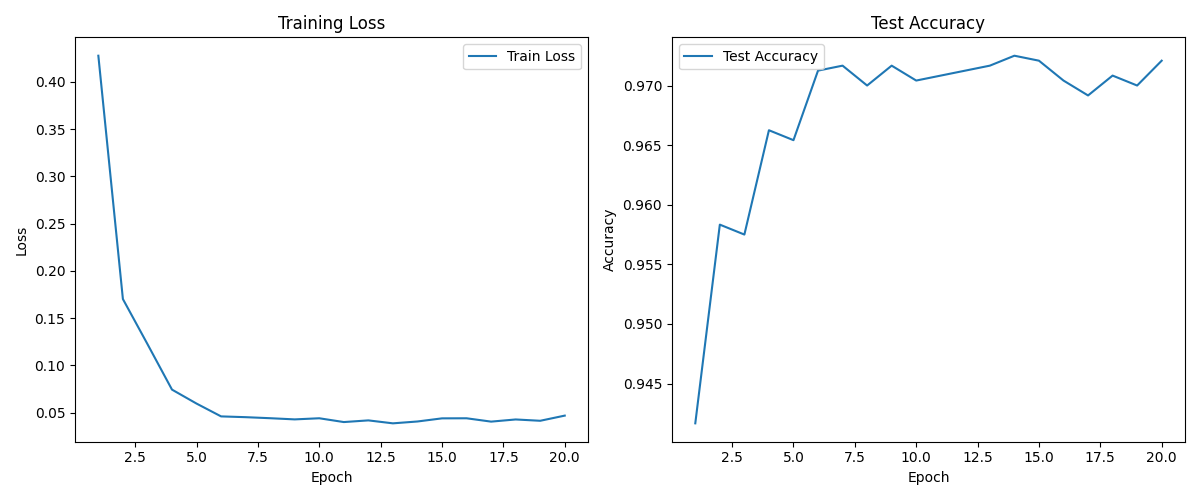

In [42]:
display(Image(filename="resnet34_training_metrics.png"))

Resnet34 Model Report

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.99      0.94      0.97       160
     Airport       0.96      0.95      0.95       160
       Beach       0.99      1.00      0.99       160
        City       0.98      0.96      0.97       160
      Desert       0.97      0.97      0.97       160
      Forest       0.98      0.98      0.98       160
   Grassland       0.96      0.99      0.98       160
     Highway       0.97      0.97      0.97       160
        Lake       0.97      0.97      0.97       160
    Mountain       0.96      0.94      0.95       160
     Parking       0.98      0.99      0.98       160
        Port       0.99      0.99      0.99       160
     Railway       0.93      0.96      0.94       160
 Residential       1.00      0.99      0.99       160
       River       0.96      0.97      0.97       160

    accuracy                           0.97      2400
   macro avg       0.97      0.97 

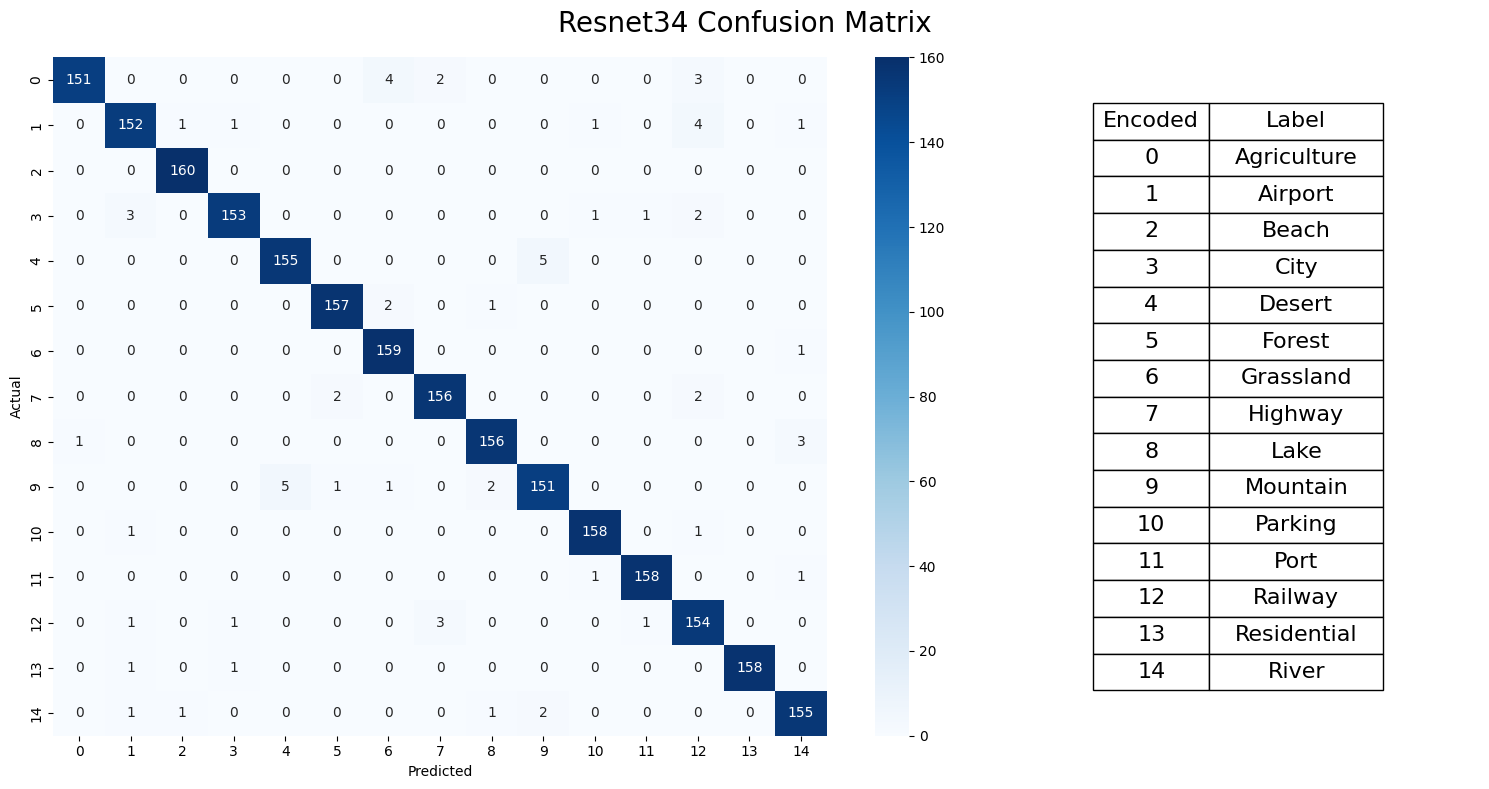

Accuracy: 0.9721
Precision: 0.9723
Recall: 0.9721
F1 Score: 0.9721


In [38]:
print(f"Resnet34 Model Report")
test_resnet_34_50(model_num=34)

### Resnet50 training loss and accurancy

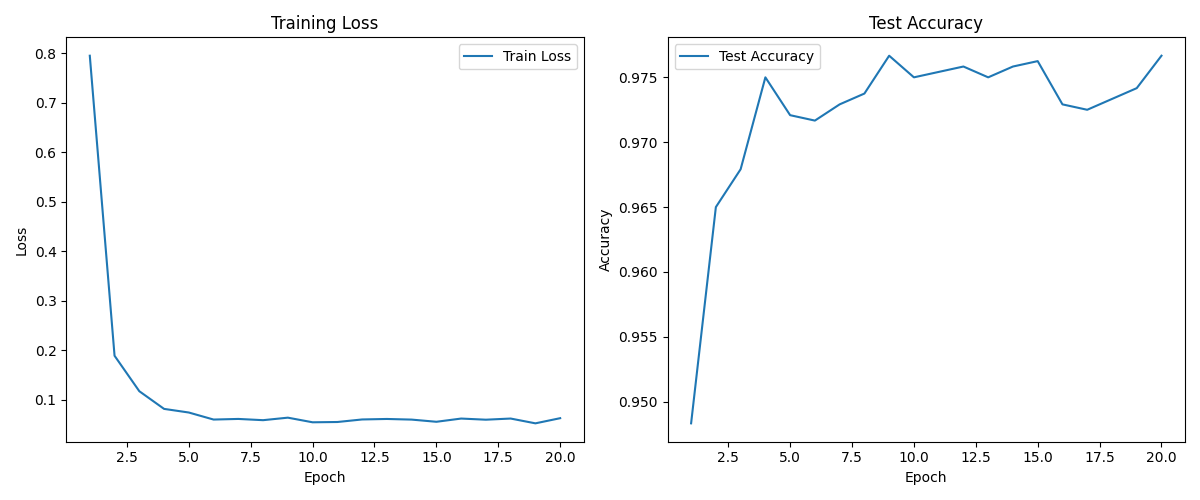

In [43]:
display(Image(filename="resnet50_training_metrics.png"))

Resnet50 Model Report

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.99      0.95      0.97       160
     Airport       0.97      0.97      0.97       160
       Beach       1.00      0.99      0.99       160
        City       0.96      0.97      0.97       160
      Desert       0.98      0.97      0.97       160
      Forest       0.99      0.98      0.98       160
   Grassland       0.97      0.98      0.98       160
     Highway       0.96      0.99      0.98       160
        Lake       0.98      0.98      0.98       160
    Mountain       0.96      0.98      0.97       160
     Parking       0.99      0.99      0.99       160
        Port       0.98      1.00      0.99       160
     Railway       0.97      0.94      0.95       160
 Residential       0.99      0.99      0.99       160
       River       0.95      0.97      0.96       160

    accuracy                           0.98      2400
   macro avg       0.98      0.98 

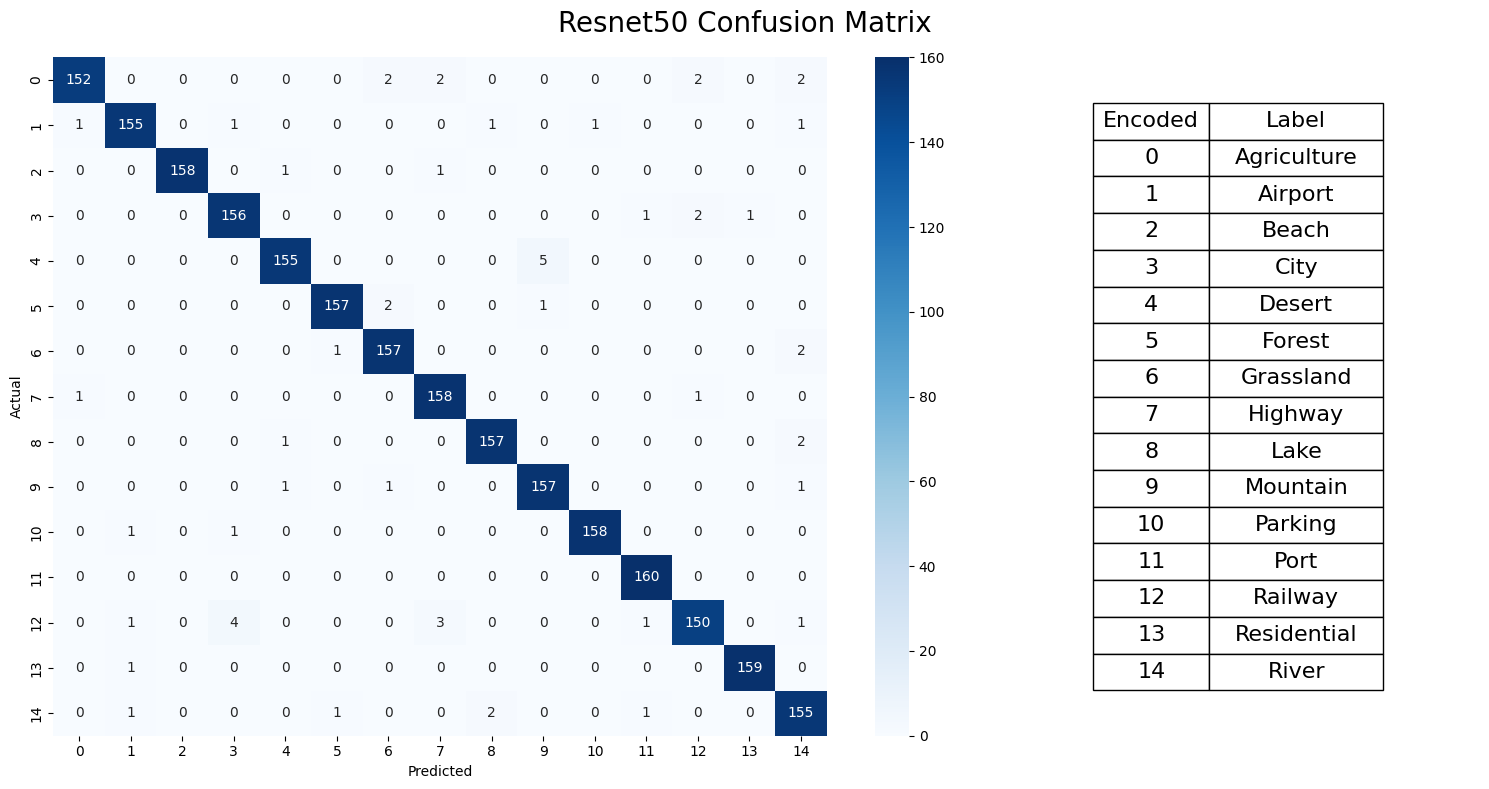

Accuracy: 0.9767
Precision: 0.9768
Recall: 0.9767
F1 Score: 0.9767


In [39]:
print(f"Resnet50 Model Report")
test_resnet_34_50(model_num=50)

# Training Performance Comparison: ResNet34 vs. ResNet50 on Skyview Image Classification

## Training Dynamics

### ResNet34
- **Initial Phase**  
  - Epoch 1: Loss 0.4276, Acc 94.17%  
  - Epoch 2–3: Rapid drop to Loss 0.1227, Acc 95.75%  
- **Mid/Late Phase**  
  - By Epoch 5: Loss 0.0597, Acc 96.54%  
  - Plateau around Loss 0.04–0.05, Acc 97.1–97.2% between Epoch 6–20  
  - Minor fluctuations (e.g. small dip at Epoch 13)

### ResNet50
- **Initial Phase**  
  - Epoch 1: Loss 0.7952, Acc 94.83%  
  - Epoch 2–3: Quick drop to Loss 0.1169, Acc 96.79%  
- **Mid/Late Phase**  
  - By Epoch 5: Loss 0.0736, Acc 97.21%  
  - Plateau around Loss 0.05–0.06, Acc 97.2–97.7% between Epoch 6–20  
  - Very stable test accuracy with minimal oscillation

## Final Evaluation Metrics

| Metric        | ResNet34   | ResNet50   |
|---------------|------------|------------|
| Test Accuracy | ~97.21%    | ~97.67%    |
| Macro F1‑Score| 0.97       | 0.97       |
| Weighted F1   | 0.97       | 0.97       |

- **Per‑Class Improvements**  
  - ResNet50 shows slight gains in challenging classes (e.g. `Railway`, `Mountain`, `Airport`), reducing misclassifications in the confusion matrix.
  - Overall, both models achieve excellent coverage, but ResNet50 edges out in precision/recall for several categories.

## Summary Recommendations

- **Rapid Prototyping**: For quick validation of model effectiveness, ResNet34 is a suitable choice.
- **High-Precision Applications**: For applications requiring higher model performance and generalization, ResNet50 is recommended.

Selecting the appropriate model architecture based on specific project requirements and resource constraints can enhance the effectiveness of image classification tasks.
